In [1]:
%matplotlib inline
import matplotlib as plt
import pandas as pd
import glob
import os
import numpy as np

In [2]:
res_df1 = pd.read_csv('../data_02/F17_alpha_1.csv',header=None)
res_df2 = pd.read_csv('../data_02/F17_alpha_0_2K.csv',header=None)
res_df = pd.concat([res_df1, res_df2])

In [3]:
print(res_df)

           0     1        2         3           4        5        6   \
0      105981  1434  359.325  10.22730   19.145600  338.033  359.149   
1      151721  1515  342.229  24.11610    4.272160  329.641  344.393   
2      210447  1486  331.039  29.67170    6.487350  354.507  337.606   
3      247827  1440  273.535  39.52020    0.474684  404.552  277.403   
4      291340  1396  345.959  17.80300   12.500000  362.278  412.269   
...       ...   ...      ...       ...         ...      ...      ...   
1995  2098469  1263  368.961  22.52840    9.155250  386.802  362.100   
1996  2492177  1368  323.268   8.58819   14.558300  260.057  319.309   
1997  4183864  1361  338.188  12.42680    5.955490  385.886  327.277   
1998  3622215  1451  343.162   4.60526  177.509000  149.804  356.198   
1999  5228163  1445  373.624   9.21716   11.147500  376.112  351.771   

             7          8         9   ...          28         29          30  \
0      12.65820    5.33708  358.2640  ...    7.502900  

In [4]:
print(res_df.shape)

(4356, 38)


In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(res_df, test_size=0.5, random_state=42)
X_train = train.iloc[:,range(1,35)].values
y_train = train.iloc[:,37].values.reshape(-1, 1)
X_test = test.iloc[:,range(1,35)].values
y_test = test.iloc[:,37].values.reshape(-1, 1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2178, 34)
(2178, 1)
(2178, 34)
(2178, 1)


In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
X_preproc = Pipeline([('stdscaler', StandardScaler()), ('minmax', MinMaxScaler(feature_range=(0, 1)))])
y_preproc = Pipeline([('onehot',OneHotEncoder(sparse=False))])

In [7]:
X_train_preproc = X_preproc.fit_transform(X_train)
X_test_preproc = X_preproc.transform(X_test)
y_train_preproc = y_preproc.fit_transform(y_train)
y_test_preproc = y_preproc.transform(y_test)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [8]:
print(X_train_preproc.shape)
print(X_test_preproc.shape)
print(y_train_preproc.shape)
print(y_test_preproc.shape)

(2178, 34)
(2178, 34)
(2178, 13)
(2178, 13)


In [9]:
print(y_train_preproc)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1187f85c0>]],
      dtype=object)

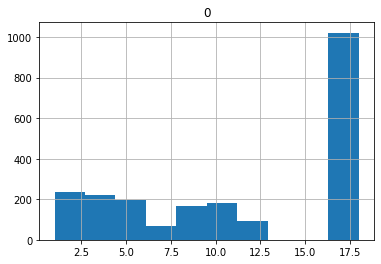

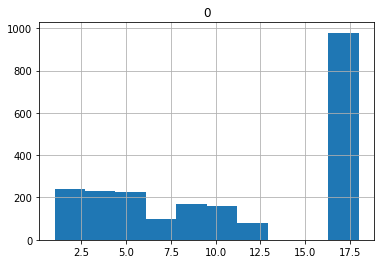

In [10]:
pd.DataFrame(y_train).hist()
pd.DataFrame(y_test).hist()

In [11]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
#encoder
input_layer = Input(shape=(X_train_preproc.shape[1],))
x = Dense(100, activation='relu',kernel_initializer='glorot_normal')(input_layer)
x = BatchNormalization()(x)
x = Dense(50, activation='relu',kernel_initializer='glorot_normal')(x)
x = BatchNormalization()(x)
x = Dense(25, activation='relu',kernel_initializer='glorot_normal')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu',kernel_initializer='glorot_normal')(x)
encoded = BatchNormalization()(x)
#encoded = x 
#classifier
output_layer = Dense(y_train_preproc.shape[1], activation='sigmoid', name='classification')(encoded)

# decoder
x_enc = Dense(25, activation='relu',kernel_initializer='glorot_normal')(encoded)
x_enc = BatchNormalization()(x_enc)
x_enc = Dense(50, activation='relu',kernel_initializer='glorot_normal')(x_enc)
x_enc = BatchNormalization()(x_enc)
x_enc = Dense(100, activation='relu',kernel_initializer='glorot_normal')(x_enc)
x_enc = BatchNormalization()(x_enc)
decoded = Dense(X_train_preproc.shape[1], name='autoencoder')(x_enc) 


model = Model(inputs=input_layer, outputs=[output_layer])
model.compile(loss={'classification': 'categorical_crossentropy'},
              optimizer='adam',
              metrics={'classification': 'accuracy'})


#model = Model(inputs=input_layer, outputs=[output_layer])
#model.compile(loss='categorical_crossentropy',
#              optimizer='adam',
#              metrics={'classification': 'accuracy'})

model.summary()

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

/usr/local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 34)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3500      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
batch_normalization_3 (Batch (None, 25)                10

In [12]:
from imblearn.keras import BalancedBatchGenerator
from imblearn.keras import BalancedBatchGenerator
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
batch_size = 32
early_stopping = EarlyStopping(monitor='acc', patience=10, verbose=1, mode='auto')
callbacks_list = [early_stopping]
#history = model.fit(X_train_preproc, 
#          {'classification': y_train_preproc},
#          batch_size=batch_size,
#          validation_data= (X_test_preproc, {'classification': y_test_preproc}),
#          callbacks=callbacks_list, epochs=1000, verbose=1)

#training_generator = BalancedBatchGenerator(X_train_preproc, y_train_preproc, sampler=RandomOverSampler(), batch_size=batch_size, random_state=42)
#history = model.fit_generator(generator=training_generator, callbacks=callbacks_list, validation_data= (X_train_preproc, {'classification': y_train_preproc}), epochs=1000, verbose=1)
#history = model.fit(X_train_preproc, y_train_preproc, callbacks=callbacks_list, validation_data= (X_test_preproc, y_test_preproc), epochs=1000, verbose=1)


history = model.fit(X_train_preproc, 
          {'classification': y_train_preproc},
          batch_size=batch_size,
          callbacks=callbacks_list,
          validation_data= (X_test_preproc, {'classification': y_test_preproc}),
          epochs=1000, verbose=1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2178 samples, validate on 2178 samples
Epoch 1/1000
2178/2178 [==============================] - 1s 667us/step - loss: 2.3615 - acc: 0.2590 - val_loss: 2.1477 - val_acc: 0.4137
Epoch 2/1000
2178/2178 [==============================] - 0s 104us/step - loss: 2.0725 - acc: 0.4991 - val_loss: 2.0498 - val_acc: 0.4986
Epoch 3/1000
2178/2178 [==============================] - 0s 106us/step - loss: 1.8454 - acc: 0.5836 - val_loss: 1.7882 - val_acc: 0.5500
Epoch 4/1000
2178/2178 [==============================] - 0s 100us/step - loss: 1.6152 - acc: 0.6001 - val_loss: 1.9588 - val_acc: 0.4454
Epoch 5/1000
2178/2178 [==============================] - 0s 99us/step - loss: 1.4438 - acc: 0.6056 - val_loss: 1.4606 - val_acc: 0.6047
Epoch 6/1000
2178/2178 [==============================] - 0s 100us/step - loss: 1.3258 - acc: 0.6281 - val_loss: 1.3464 - val_acc: 0.6097
Epoch 7/1000
2178/2178 [=======

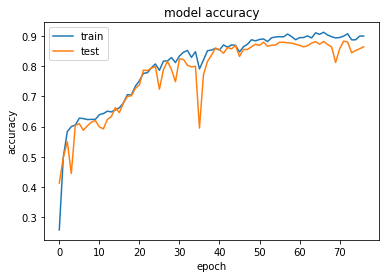

In [13]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
y_test_preproc_pred = model.predict(X_test_preproc)

In [15]:
print(y_test_preproc_pred)

[[7.39097595e-06 1.49011612e-07 2.08616257e-07 ... 1.27464533e-04
  3.36766243e-06 8.47876072e-05]
 [5.91278076e-05 2.47776508e-04 4.84044850e-02 ... 1.36792660e-05
  2.89916992e-04 2.27153301e-04]
 [5.78165054e-06 9.23871994e-07 8.94069672e-08 ... 7.19161332e-02
  2.47031450e-04 8.91983509e-05]
 ...
 [6.47246838e-04 2.67922878e-05 1.21593475e-05 ... 3.37839127e-04
  2.16197968e-03 7.24881411e-01]
 [4.21673059e-04 4.25279140e-05 2.25603580e-05 ... 1.03175640e-04
  2.00867653e-04 6.32856250e-01]
 [2.66432762e-04 1.03801489e-04 3.95178795e-05 ... 8.56816769e-05
  2.71121797e-04 2.29713455e-01]]


In [16]:
import numpy as np
from keras.utils import to_categorical
y_test_preproc_pred1 = to_categorical(np.argmax(y_test_preproc_pred,axis=1))

In [17]:
print(y_test_preproc)
print(y_test_preproc_pred1)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [18]:
y_test1 = y_preproc.inverse_transform(y_test_preproc)
y_pred1 = y_preproc.inverse_transform(y_test_preproc_pred1)

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test1, y_pred1)

array([[ 95,  24,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 12,  85,  19,   2,   0,   0,   0,   0,   0,   0,   0,   0,   1],
       [  0,   2,  75,   9,   1,   1,   0,   0,   0,   0,   0,   0,   3],
       [  0,   0,  33,  76,  25,   5,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   2,  91,  23,   2,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   4,  82,  18,   2,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   3,  14,  53,  26,   1,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   5,  75,   9,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  13,  64,   3,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   2,   7,  54,   2,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   6,  79,   7,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  75,   1],
       [  0,   0,   0,   0,   0,   1,   1,   0,   0,   0,   0,   0, 977]])

Confusion matrix, without normalization
[[ 95  24   2   0   0   0   0   0   0   0   0   0   0]
 [ 12  85  19   2   0   0   0   0   0   0   0   0   1]
 [  0   2  75   9   1   1   0   0   0   0   0   0   3]
 [  0   0  33  76  25   5   0   0   0   0   0   0   0]
 [  0   0   0   2  91  23   2   0   0   0   0   0   0]
 [  0   0   0   0   4  82  18   2   0   0   0   0   0]
 [  0   0   0   0   3  14  53  26   1   0   0   0   1]
 [  0   0   0   0   0   0   5  75   9   0   0   0   0]
 [  0   0   0   0   0   0   0  13  64   3   0   0   0]
 [  0   0   0   0   0   0   0   2   7  54   2   0   0]
 [  0   0   0   0   0   0   0   0   0   6  79   7   2]
 [  0   0   0   0   0   0   0   0   0   0   3  75   1]
 [  0   0   0   0   0   1   1   0   0   0   0   0 977]]


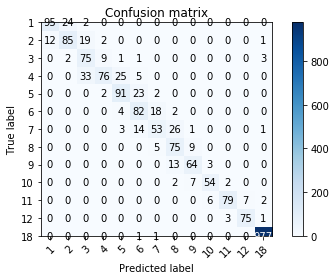

In [20]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)
class_names = np.unique(np.sort(res_df.iloc[:,37].values))
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test1, y_pred1, classes=class_names,
                      title='Confusion matrix')


In [21]:
X_data = np.concatenate((X_train_preproc,X_test_preproc))
y_data = np.concatenate((y_train,y_test))

In [22]:
encoder = Model(input_layer, encoded)
preds = encoder.predict(X_data)

In [23]:
preds

array([[ 0.85, -1.73,  1.98, ..., -1.88,  2.07, -1.98],
       [ 1.57, -3.17, -1.33, ..., -4.63, -0.12, -1.57],
       [ 1.6 , -0.74,  2.54, ..., -0.84,  2.39, -1.98],
       ...,
       [ 0.93, -0.48,  1.73, ..., -2.97,  2.77, -1.98],
       [ 1.02, -2.04,  2.11, ..., -2.02,  2.24, -1.98],
       [ 2.32, -0.78,  2.03, ..., -1.91,  1.77, -1.06]], dtype=float32)

In [24]:
import numpy as np
from sklearn.manifold import TSNE

In [25]:
X_embedded = TSNE(n_components=2,random_state=100).fit_transform(preds)

In [26]:
print(X_embedded.shape)
print(y_data.shape)

(4356, 2)
(4356, 1)


In [27]:
np.unique(y_test)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 18])

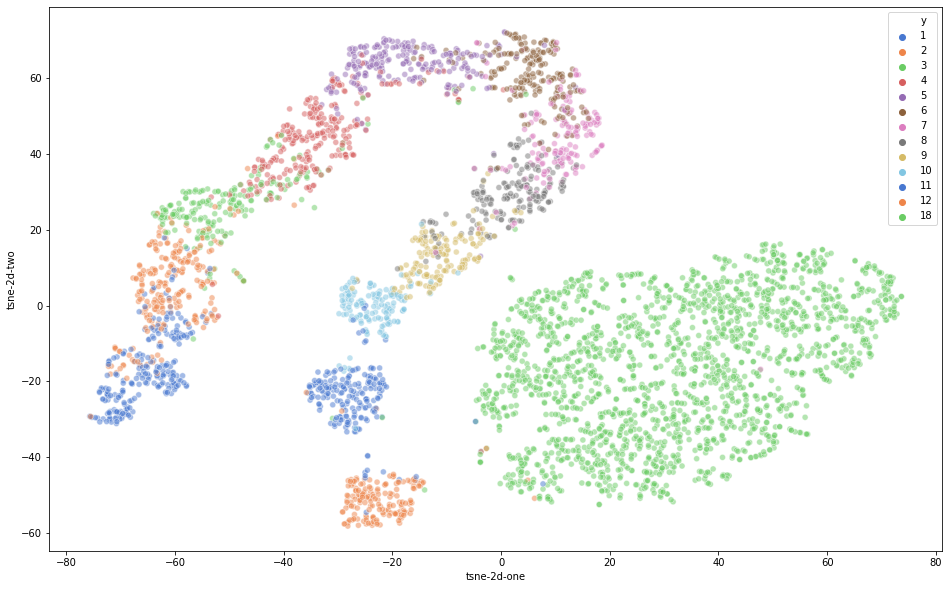

In [28]:
import seaborn as sns
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = X_embedded[:,0]
df_subset['tsne-2d-two'] = X_embedded[:,1]
df_subset['y'] = y_data
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("muted", 13),
    data=df_subset,
    legend="full",
    alpha=0.5
)

In [29]:
import umap
X_trans = umap.UMAP(n_neighbors=10, random_state=42).fit(preds)
X_embedded = X_trans.transform(preds)

/usr/local/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../usr/local/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/usr/local/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../usr/local/lib/python3.7/site-packages/umap/utils.py", line

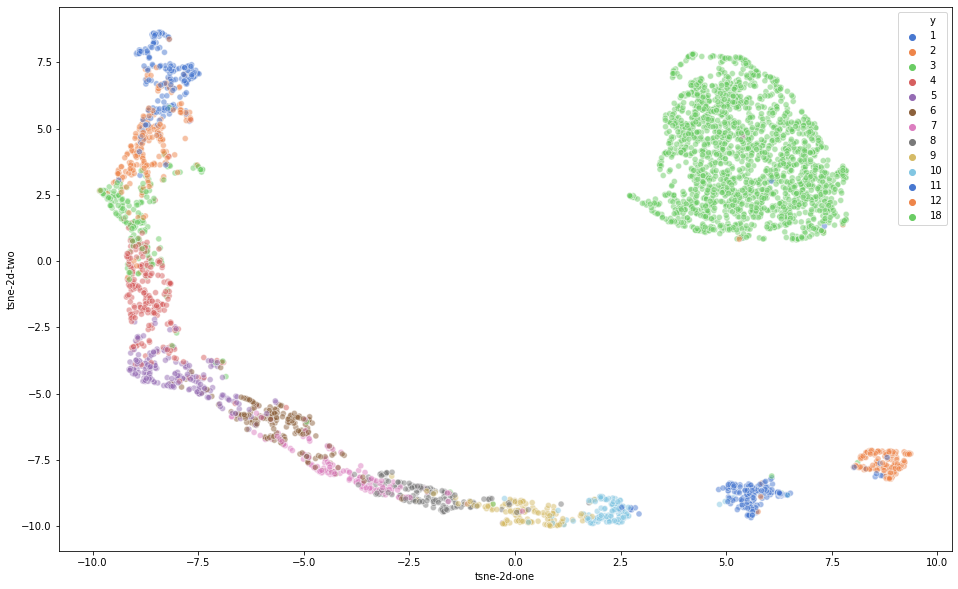

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = X_embedded[:,0]
df_subset['tsne-2d-two'] = X_embedded[:,1]
df_subset['y'] = y_data
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("muted", 13),
    data=df_subset,
    legend="full",
    alpha=0.5
)

In [31]:
filename = '../data_02/F17_alpha_0_2K.csv'

(2000, 34)
(2000, 1)
(2000,)


/usr/local/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../usr/local/lib/python3.7/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  self.func_ir.loc))
/usr/local/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../usr/local/lib/python3.7/site-packages/umap/nndescent.py", line 

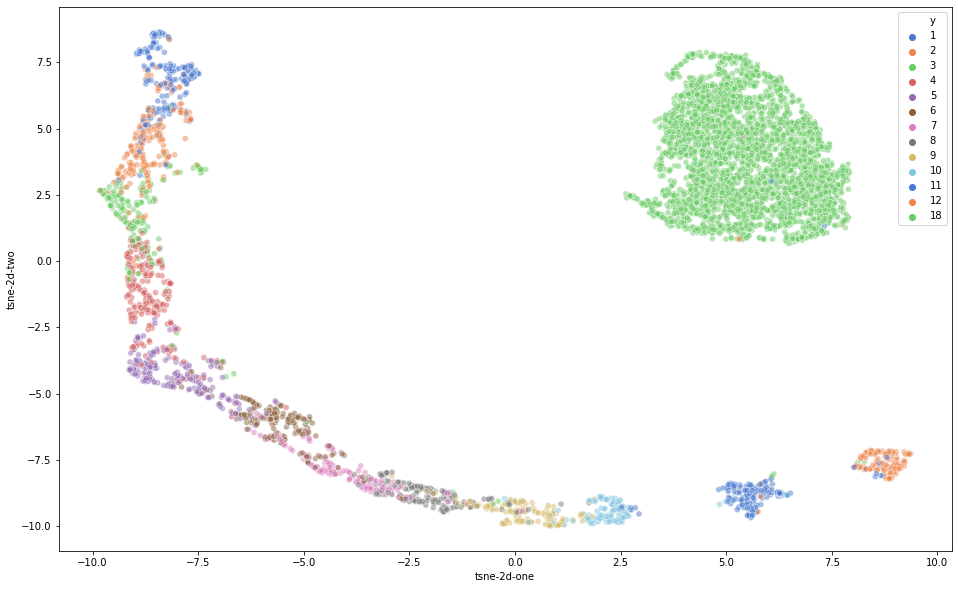

In [32]:
chunksize = 10 ** 6
res_df = pd.DataFrame()
cntr  = 0
tag = 'suppervised_classifier'
for test in pd.read_csv(filename, chunksize=chunksize, header=None):
    #test = test.astype(np.float32)
    X_test = test.iloc[:,range(1,35)].values
    y_test = test.iloc[:,37].values.reshape(-1, 1)
    ids = test.iloc[:,0].values
    print(X_test.shape)
    print(y_test.shape)
    print(ids.shape)
    X_test_preproc = X_preproc.transform(X_test)
    preds = encoder.predict(X_test_preproc)
    X_embedded = X_trans.transform(preds)
    df_subset1 = pd.DataFrame()
    df_subset1['tsne-2d-one'] = np.concatenate([X_embedded[:,0],df_subset['tsne-2d-one'].values]) 
    df_subset1['tsne-2d-two'] = np.concatenate([X_embedded[:,1],df_subset['tsne-2d-two'].values]) 
    df_subset1['y'] = np.concatenate([y_test,y_data])
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("muted", 13),
        data=df_subset1,
        legend="full",
        alpha=0.5
    )
    result_df = pd.DataFrame()
    result_df['ids'] = ids
    result_df['dim-2d-one'] = X_embedded[:,0]
    result_df['dim-2d-two'] = X_embedded[:,1]
    result_df['event'] = y_test
    result_df.to_csv('../results_02/%s_%010d.csv.gz'%(tag,cntr),index=False,compression='gzip')
    cntr = cntr + 1
    break